# calculating concentrations from normal curves
+ ### standard curves are stored in raw data and have to be retrieved
+ ### respective concentrations for the dilution series are stored in the plex info
+ ### 5LP regression has to be fitted for every standard curve

## load in the raw data from the master table

In [313]:
pd.options.mode.chained_assignment = None
home = os.environ['HOME']
data_path = os.path.join(home, "/Users/martinszyska/Dropbox/Icke/Work/Luminex/output")
excel_master = os.path.join(data_path, "luminexcel.xlsx")

### load from excel

In [314]:
col_df = pd.read_excel(excel_master, sheet_name="Plexes")
data_df = pd.read_excel(excel_master, sheet_name="RawData")
data_df

,Run,Plex,Well,Type,Gene,FI,SamplingErrors
0,20211021,11-Plex,A1,S1,M-CSF,4599.5,NaN
1,20211021,11-Plex,A1,S1,CXCL9/MIG,11176.5,NaN
2,20211021,11-Plex,A1,S1,CXCL7/NAP2,16447.0,NaN
3,20211021,11-Plex,A1,S1,CXCL6/GCP2,11222.0,NaN
4,20211021,11-Plex,A1,S1,CXCL11/I-TAC,7054.0,NaN
...,...,...,...,...,...,...,...
11695,20211222,38-Plex,H6,NaN,IL-7,25.0,NaN
11696,20211222,38-Plex,H6,NaN,MIP-1ß,64.0,NaN
11697,20211222,38-Plex,H6,NaN,TNF-a,26.0,NaN
11698,20211222,38-Plex,H6,NaN,TNFß,14.0,NaN


### standards are retrieved from the DB
+ all standards have pattern `S[1-8]`
+ from the col_df, we get the initial concentrations for the dilution series
+ the dilution is filled as a 4-fold dilution

In [318]:
def get_standard(data_df, col_df, run="20211021", gene='M-CSF', dilution=4):
    '''
    returns the standard for that run and the respective gene
    '''
    
    # retrieve only the controls from the raw data
    control_df = data_df.loc[data_df['Type'].fillna("").str.match(r"^[SC][1-9]?"),:]
    
    run = int(run)
    # retrieve standards and control from control_df
    s = control_df.query('Run == @run and Gene == @gene')
    ss = s.loc[s['Type'].str.match(r"^S[1-8]$"),:]
    sc = s.loc[s['Type'].str.match("^C[12]$"),:]
    
    # get the starting concentration for that dilution
    conc = col_df.query('Run == @run and Gene == @gene')['S1_conc'].iloc[0]
    # fill the dilution series with the last being 0
    ss.loc[:, 'conc'] = conc / np.power(dilution, ss.loc[:, 'Type'].str.extract("S([1-8])").astype(int)-1)
    ss.loc[ss['Type'] == "S8", 'conc'] = 0.001
    return ss.loc[:, ['Run', 'Gene', 'conc', 'FI']]

In [319]:
s = get_standard(data_df, col_df, run="20211021", gene='M-CSF')
s

,Run,Gene,conc,FI
0,20211021,M-CSF,100000.000000,4599.5
11,20211021,M-CSF,100000.000000,4784.0
88,20211021,M-CSF,25000.000000,1685.0
99,20211021,M-CSF,25000.000000,1925.0
176,20211021,M-CSF,6250.000000,573.5
187,20211021,M-CSF,6250.000000,544.0
264,20211021,M-CSF,1562.500000,154.0
275,20211021,M-CSF,1562.500000,160.0
352,20211021,M-CSF,390.625000,64.0
363,20211021,M-CSF,390.625000,71.0


### fit the standard to 5PL-Regression
+ formulate the regression formula with 5 parameters  f(conc) = FI
+ compute the residuals for FI - f(conc) for a given parameter set
+ fit the parameters by minimizing the squares errors
+ calculate the R-squared for QC

In [522]:
from scipy.optimize import leastsq, least_squares


def PL5(conc,params):
    '''
    equation for regression
    f(conc) = FI
    '''
    
    A,B,C,D,E = params
    return A + (B-A)/np.power(1+np.power(conc/C, D), E)

def PL5_retro(fi, params):
    '''
    equation for deriving conc from FI
    '''
    
    A,B,C,D,E = params
    
    return C * np.power(np.power((B-A)/(fi-A), 1/E)-1, 1/D)
    
    
def residuals(params, x, y):
    return y - PL5(x,params)


def r_squared(params, s):
    '''
    regression coefficient
    '''
    
    y_mean = np.mean(s['FI'])
    
    res_ss = np.sum(residuals(params, s['conc'], s['FI']) ** 2)
    tot_ss = np.sum((s['FI'] - y_mean)**2)
    return 1 - (res_ss / tot_ss)
    

def fit_standard(s):
    '''
    takes a standard with columns conc and FI 
    and returns the params for the 5LP regression
    '''
    
    # init the params to sensible values (domain-specific)
    p0 = [10, 1000, 10000, -1, 1]
    
    # fit using leastsq
    plsq = least_squares(residuals, p0, jac="2-point", method="trf", args=(s['conc'], s['FI']),bounds=([-np.inf,-np.inf,-np.inf,-1,0.1],[np.inf, np.inf, np.inf,0,5]))
    
    params = plsq['x']
    
    return params, r_squared(params, s)

In [523]:
params, R = fit_standard(get_standard(data_df, col_df, run="20211021", gene='M-CSF'))
R

0.9987658030561741

In [525]:
PL5_retro(s['FI'], params)

0       96694.246023
11     103382.846119
88      22902.964222
99      27153.334697
176      6457.112132
187      6087.251164
264      1465.490445
275      1533.789483
352       430.994478
363       513.551770
429       123.272496
440       123.272496
506         8.719813
517              NaN
583              NaN
594              NaN
Name: FI, dtype: float64

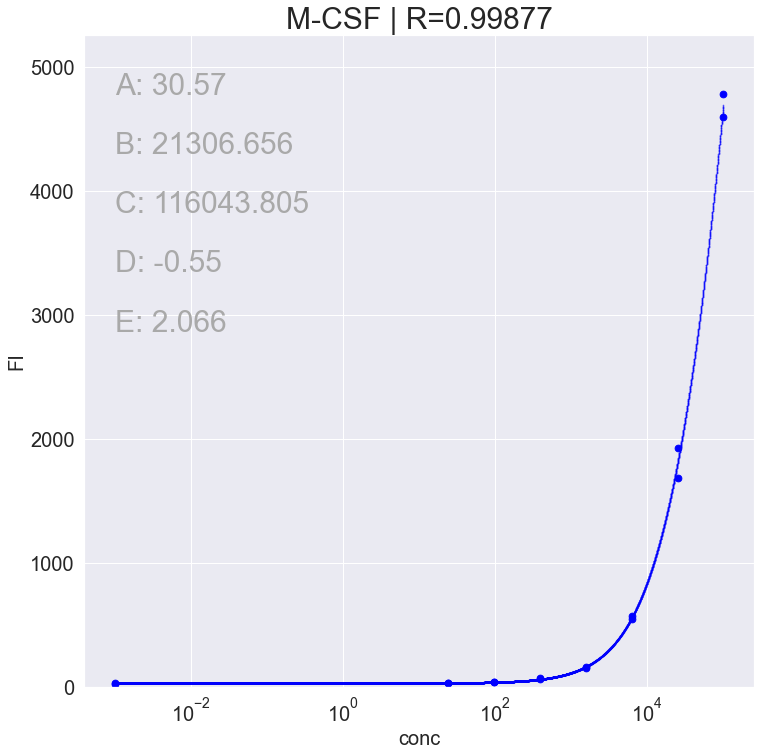

In [524]:
plot_s(run="20211021", gene='M-CSF')

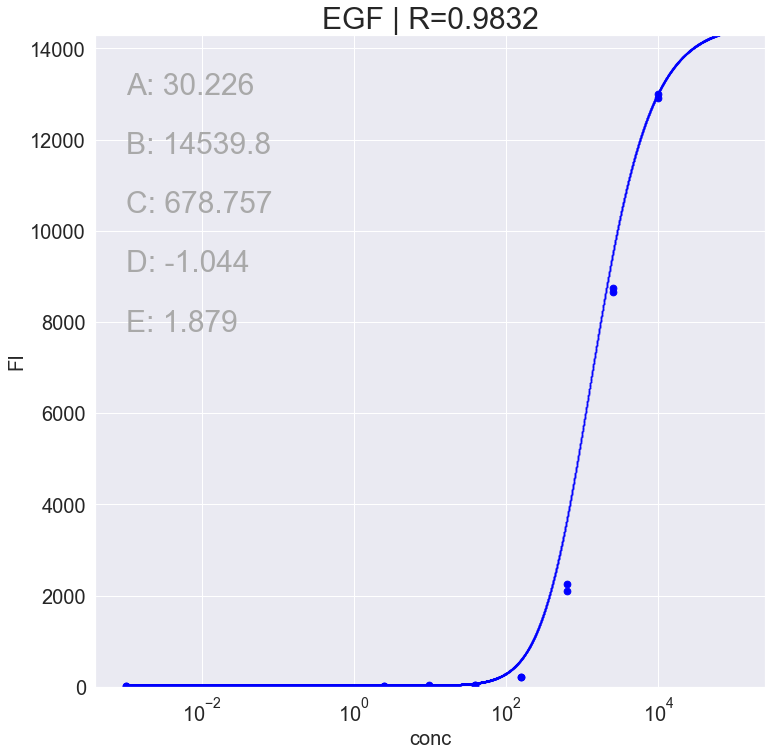

In [512]:
params = get_params_from_string("Std. Curve: FI = 30,2261 + (14539,8 - 30,2261) / ((1 + (Conc / 678,757)^-1,04439))^1,87946")

plot_s(run="20211222", gene='EGF', params=params)

### plot the curve for the individual fit

In [502]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
import re

def get_params_from_string(string):
    '''
    extracts the params from the luminex curve fit string
    '''
    
    A,B,_,C,D,E = [float(f) for f in re.findall(r"-?[0-9]+\.[0-9]+", string.replace(",", "."))]
    return [A,B,C,D,E]


def plot_data(ax, s, conc, fit, color="red"):
    _ = ax.scatter(conc, fit, color=color, s=.5, alpha=0.5)
    _ = ax.scatter(s['conc'], s['FI'], color=color, s=45)


def fit_curve(s):
    '''
    returns the fit curve for plotting
    '''
    params, R = fit_standard(s)
    conc = np.power(10, np.linspace(-3, 5, 10000))
    fit = logistic5(conc, params)

    return conc, fit, R, params


def plot_params(s, params):
    '''
    plots the params info
    '''
    

    return ax


def plot_s(gene="M-CSF", run="20211021", fit=True, params=[]):
    '''
    retrieve the standard curve and plot along with fit line
    '''
    # init the plot
    fig, ax = plt.subplots(figsize=(12,12))
    
    
    s = get_standard(data_df, col_df, run=run, gene=gene)
    
    
    # fit the curve if no params are given
    if fit:
        if len(params):
            # use params to plot the curve
            R = r_squared(params, s)
            conc = np.power(10, np.linspace(-3, 5, 10000))
            fit = logistic5(conc, params)  
        else:
            # fit the curve
            conc, fit, R, params = fit_curve(s)
            params = list(params)
        
    plot_data(ax, s, conc, fit, color="blue")
    
    # plots the params info
    ymax = s['FI'].max()
    x = 0.001
    for i,p in enumerate("ABCDE"):
        _ = ax.text(x,ymax - i*ymax/10, f"{p}: {round(params[i],3)}", size=30, color="darkgray")
    
    _ = ax.set_ylim(0,ymax*1.1)
    _ = ax.set_xscale('log')
    _ = ax.set_xlabel('conc', fontsize=20)
    _ = ax.set_ylabel('FI', fontsize=20)
    _ = plt.xticks(fontsize=20)
    _ = plt.yticks(fontsize=20)
    plt.title(f"{gene} | R={round(R,5)}", fontsize=30)
    
    return

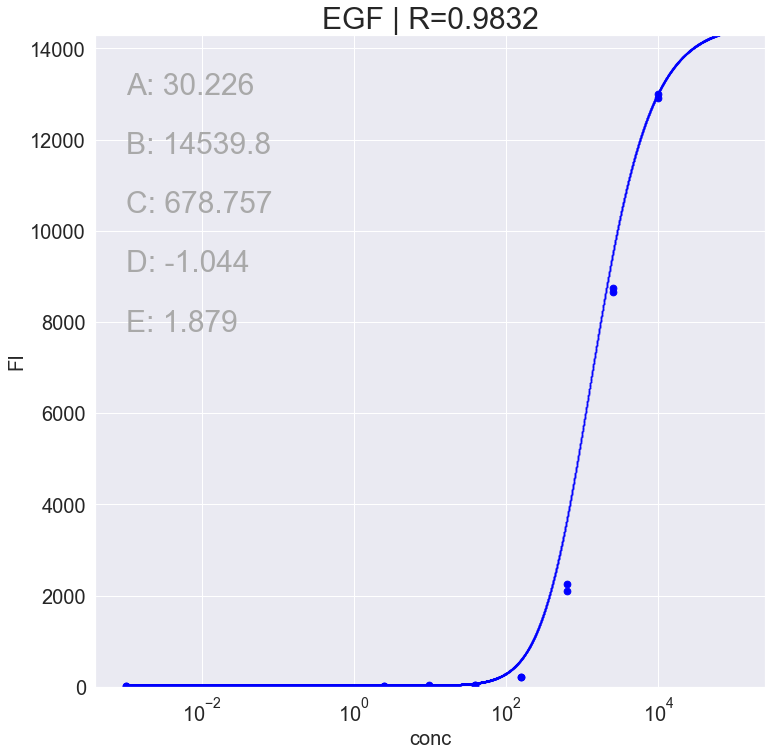

In [503]:
params = get_params_from_string("Std. Curve: FI = 30,2261 + (14539,8 - 30,2261) / ((1 + (Conc / 678,757)^-1,04439))^1,87946")

plot_s(run="20211222", gene='EGF', params=params)

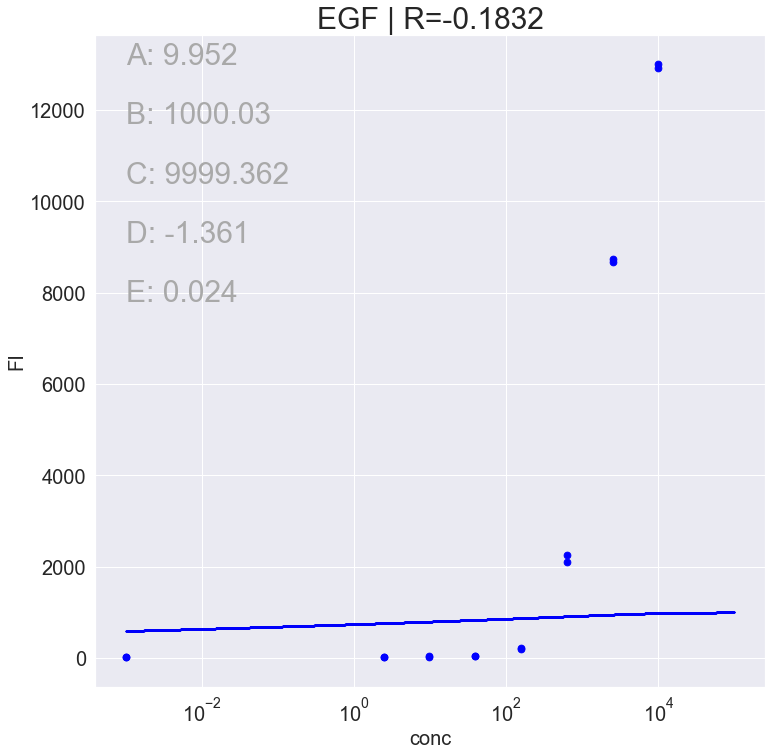

In [439]:
plot_s(run="20211222", gene='EGF')

In [299]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
def plot_multi_s(gene="M-CSF", runs=["20211021", "20211222"]):
    s = {}
    
    for d in runs:
        s[d] = get_standard(data_df, col_df, run=d, gene=gene)
    fig, ax = plt.subplots(figsize=(12,12))
    c = {"20211021":"red", "20211222":"green"}
    for r in runs:
        _ = ax.scatter(s[r]['conc'], s[r]['FI'], color=c[r], label=r)
        _ = ax.set_xscale('log')
        _ = ax.set_xlabel('conc', fontsize=28)
        _ = plt.xticks(fontsize=20)
        _ = plt.yticks(fontsize=20)
        plt.title(gene, fontsize=20)

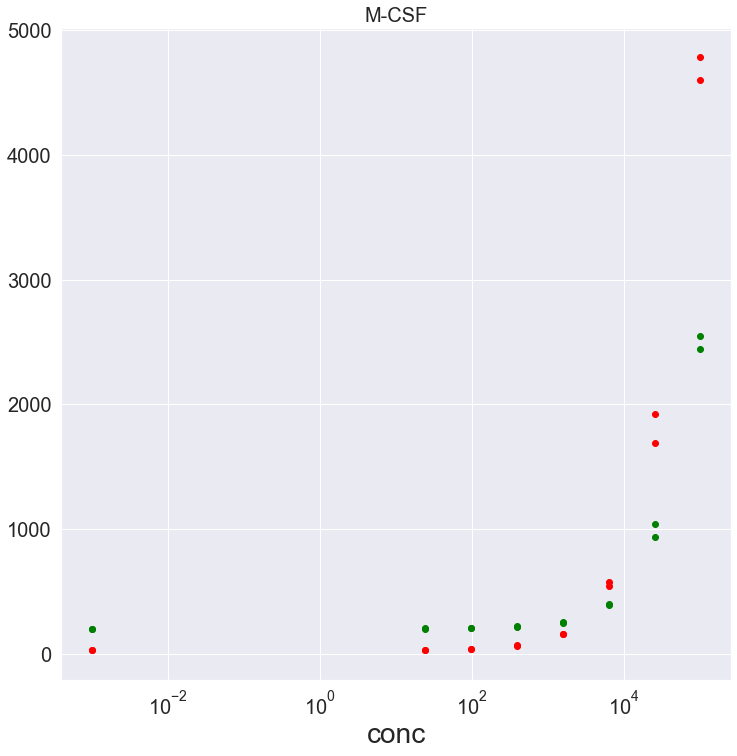

In [519]:
_ = plot_multi_s(gene="M-CSF")

### new plot function with curve fitting

In [184]:
def plot_multi_s(gene="M-CSF", runs=["20211021", "20211222"]):
    
    fig, ax = plt.subplots(figsize=(12,12))
    c = {"20211021":"red", "20211222":"green"}
    _ = ax.set_xscale('log')
    _ = ax.set_xlabel('conc', fontsize=28)
    for r in runs:
        s = get_standard(data_df, col_df, run=d, gene=gene)
        # fit the curve
        conc, fit, R = fit_curve(s)
        ax = plot_data(ax, s, conc, fit, color=c[r])
    _ = plt.xticks(fontsize=20)
    _ = plt.yticks(fontsize=20)
    plt.title(gene, fontsize=20)

array([ 3.05700900e+01,  2.13066115e+04,  1.16043754e+05, -5.50432658e-01,
        2.06591720e+00])

In [163]:
p = [27.863, 7268.64, 101819, -1.51961, 0.62292]

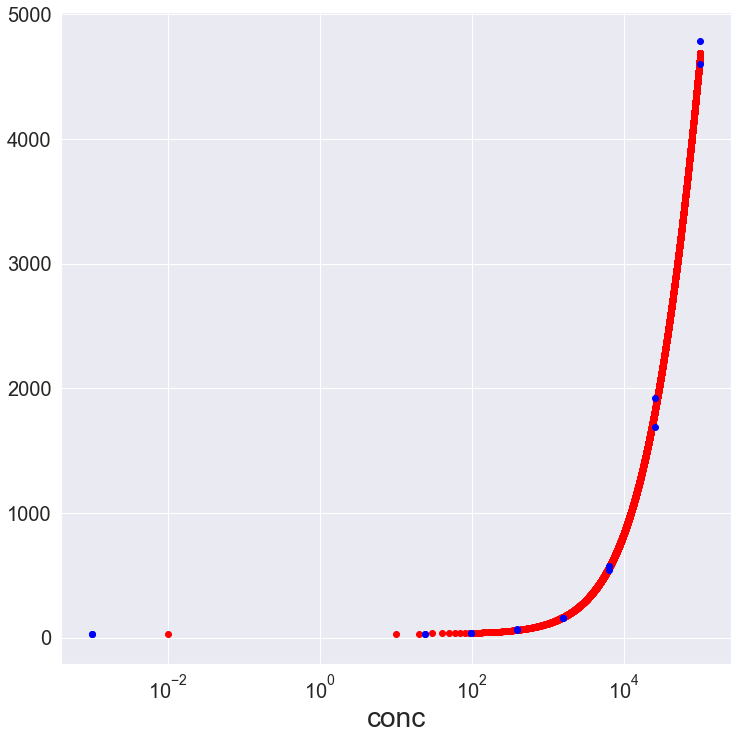

In [298]:
fig, ax = plt.subplots(figsize=(12,12))
_ = ax.scatter(conc, fit, color="red")
_ = ax.scatter(s['conc'], s['FI'], color="blue")
_ = ax.set_xscale('log')
_ = ax.set_xlabel('conc', fontsize=28)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

In [178]:
test = "Std. Curve: FI = 45,3591 + (11755,9 - 45,3591) / ((1 + (Conc / 2144,72)^-2,01471))^0,515531"
p2 = [45.3591, 11755.9, 2144.72, -2.01471, 0.515531]